In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import os,sys
import random
from skimage.transform import resize
import models
sys.path.insert(0,'/home/huangz78/hydro/unet3d/')
from models.unet3d_model import UNet3D, ResidualUNet3D
from models.dnet import weights_init,Discriminator
from models.utils import illustrate, visualization, noise_generate
from train import gan_train
from importlib import reload

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
ngpu = 0
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
netD = Discriminator(ngpu).to(device)
        
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
# print(netD)

Conv3d(1, 64, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
LeakyReLU(negative_slope=0.2, inplace=True)
Conv3d(64, 128, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.2, inplace=True)
Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.2, inplace=True)
Conv3d(256, 512, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.2, inplace=True)
Conv3d(512, 1024, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.2, inplace=True)
Conv3d(1024, 

Discriminator(
  (main): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv3d(64, 128, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (6): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv3d(256, 512, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (9): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv3d(512, 1024, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias

In [ ]:
reload(train)
# reload(models.buildingblocks)
# reload(models.utils)
from train import gan_train

In [4]:
gnet = UNet3D(1,1,is_segmentation=False,final_sigmoid=False)
dnet = Discriminator(ngpu)
gan_train(gnet,dnet,lrg=1e-4,lrd=1e-4,traintotal=2000,testtotal=10,dep=8,update_D_every=10,\
          b_size=5,num_epochs=1,weight_DD=1,\
          print_every=10,validate_every=10,fileexp_ind=5010,\
          ngpu=ngpu,manual_seed=manualSeed,\
          make_plot=True,save_cp=True)

Total amount of available files: 13798
Train file amount: 2000
Test file amount: 10
weight of DD =  1
Starting Training Loop...
> /home/huangz78/hydro/train.py(92)gan_train()
     90     dynexp   = torch.tensor(dynexp).to(torch.float).to(device); noiseexp = torch.tensor(noiseexp).to(torch.float).to(device)
     91     breakpoint()
---> 92     for epoch in range(num_epochs):
     93         try:
     94             fileind = 0; global_step = 0; D_update_ind = 0

ipdb> val_loss,nrmse = validate(testfiles,netD,netG,dep=dep,batchsize=5,\                                         seed=manual_seed,img_size=img_size,sigmoid_on=sigmoid_on,device=device)
*** SyntaxError: unexpected character after line continuation character
ipdb> val_loss,nrmse = validate(testfiles,netD,netG,dep=dep,batchsize=5,seed=manual_seed,img_size=img_size,sigmoid_on=sigmoid_on,device=device)
ipdb> p nrmse
tensor([0.3373])
ipdb> list
     87     dynexp[0,0,:,:,:]  = dynexp[0,0,:,:,:] / normalize_factor
     88     for t in

BdbQuit: 

### tuning each net

In [3]:
torch.norm(noise,'fro')/torch.norm(dyn,'fro')

tensor(0.6110)

Total amount of files: 13798


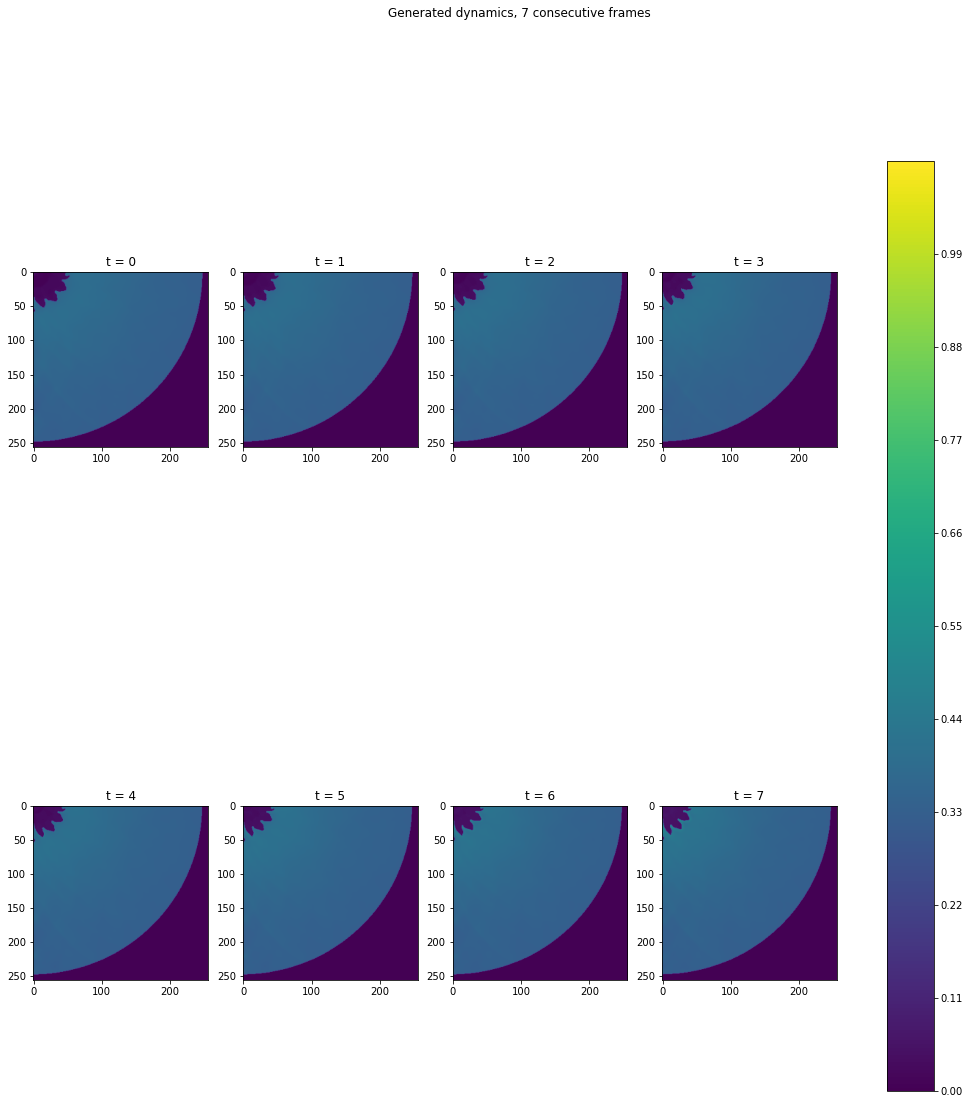

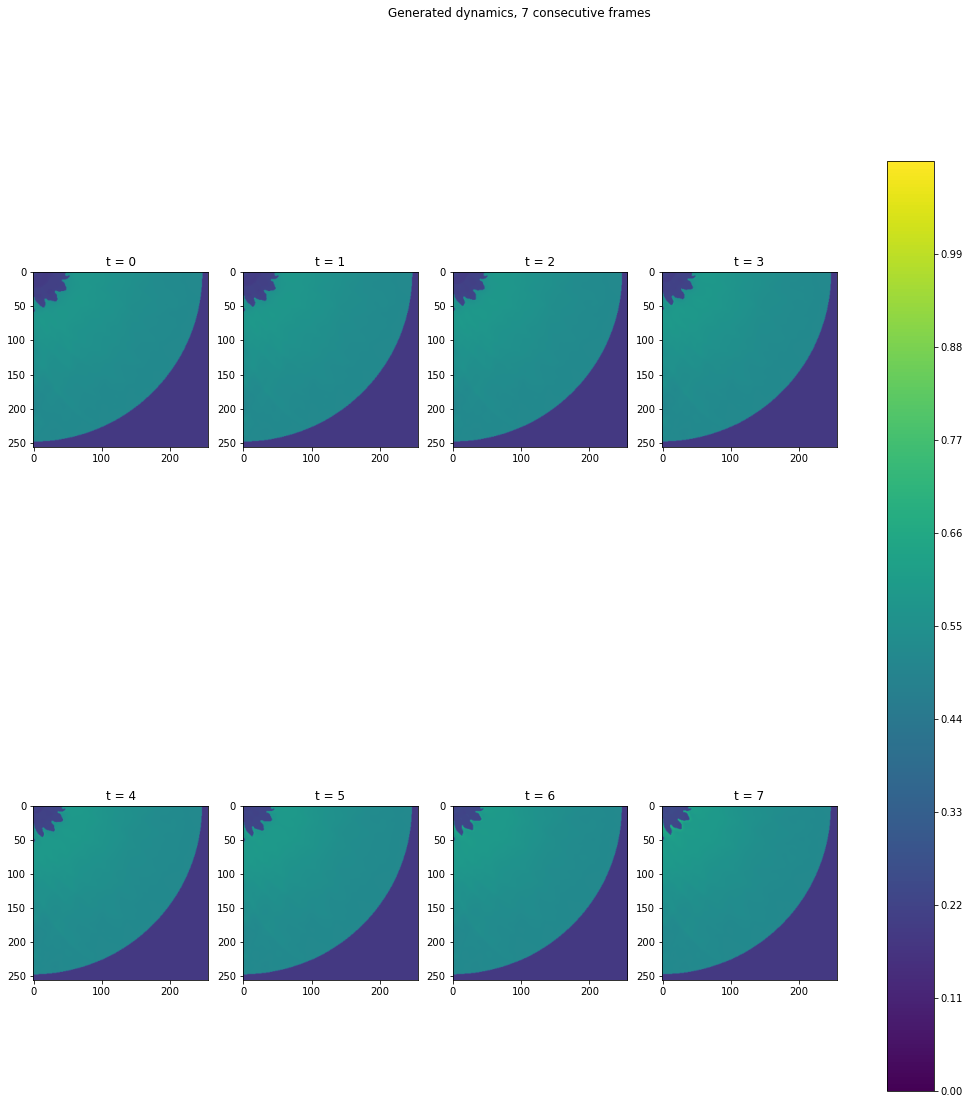

In [2]:
datapath = '/mnt/shared_b/data/hydro_simulations/data/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of files:', len(ncfiles))
img_size = 320
dep = 8
fileexp_ind = 5010
# val = []
# for fileexp_ind in range(len(ncfiles)):
filename = ncfiles[fileexp_ind]
sim = xr.open_dataarray(datapath+filename)
# val.append(np.max(np.array(sim)[:dep,:,:].flatten()))
sim.close()
dyn   = np.zeros((1,1,dep,256,256))            # load one sample, show it
noise = np.zeros((1,1,dep,256,256))    # make a noise sample, add it to the ground truth, show it
for t in range(dep):
    dyn[0,0,t,:,:] = resize(sim.isel(t=t)[:img_size,:img_size].values,(256,256),anti_aliasing=True)
normalization_factor = 50
dyn[dyn>normalization_factor] = normalization_factor
# normalize_factor   = np.max( np.abs(dyn[0,0,:,:,:]).flatten() )
dyn[0,0,:,:,:]   = dyn[0,0,:,:,:] / normalization_factor
noise[0,0,:,:,:] = noise_generate(dyn[0,0,:,:,:],mode='const_rand')
# for t in range(dep): # different noise for each frame when using a 'for' loop
#     noise[0,0,t,:,:] = noise_generate(dyn[0,0,t,:,:],mode='linear') 
dyn = torch.tensor(dyn).to(torch.float); noise = torch.tensor(noise).to(torch.float)

%matplotlib inline
illustrate(dyn)
illustrate(noise + dyn)

In [9]:
# load a G net
gnet = ResidualUNet3D(1,1,num_levels=4,is_segmentation=False,final_sigmoid=False)
gnet(dyn).shape

In [8]:
reload(models)
reload(models.dnet)
from models.dnet import Discriminator

In [9]:
# load a D net
ngpu   = 0
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
netD   = Discriminator(ngpu,ndf=32).to(device)
netD.apply(weights_init)

Conv3d(1, 32, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.2, inplace=True)
Conv3d(32, 64, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.2, inplace=True)
Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.2, inplace=True)
Conv3d(128, 256, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.2, inplace=True)
Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

Discriminator(
  (main): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv3d(32, 64, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (7): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv3d(128, 256, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (10): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (

In [ ]:
# load a G net
gnet = UNet3D(1,1,is_segmentation=False,final_sigmoid=False)
gpath = '/home/huangz78/checkpoints/netG.pth'
checkpoint = torch.load(gpath)
gnet.load_state_dict(checkpoint['model_state_dict'])
print(f'G net loaded from {gpath}')

# apply denoiser, show the outcome
noisy_dyn     = noiseexp + dyn
denoised_samp = gnet(noisy_dyn)
illustrate(denoised_samp)

### scratch

In [ ]:
def outsize(hin,win,ker=(3,3),stride=(1,1),padding=(0,0),dilation=(1,1)):
    if isinstance(ker,int):
        ker=(ker,ker)
    if isinstance(stride,int):
        stride=(stride,stride)
    if isinstance(padding,int):
        padding=(padding,padding)
    if isinstance(dilation,int):
        dilation=(dilation,dilation)
    hout = int( (hin + 2*padding[0]- dilation[0]*(ker[0]-1)-1)/stride[0] + 1  )
    wout = int( (win + 2*padding[1]- dilation[1]*(ker[1]-1)-1)/stride[1] + 1  )
    return hout,wout

In [ ]:
outsize(4,4,ker=(4,4),stride=(1,1),padding=(0,0),dilation=(1,1))

In [ ]:
h1,w1 = outsize(256,256,ker=(4,4),stride=(2,2),padding=(1,1))
h2,w2 = outsize(h1,w1,ker=(4,4),stride=(2,2),padding=(1,1))
h3,w3 = outsize(h2,w2,ker=(4,4),stride=(2,2),padding=(1,1))
h4,w4 = outsize(h3,w3,ker=(4,4),stride=(2,2),padding=(1,1))
h5,w5 = outsize(h4,w4,ker=(4,4),stride=(2,2),padding=(1,1))
h6,w6 = outsize(h5,w5,ker=(4,4),stride=(2,2),padding=(1,1))
h7,w7 = outsize(h6,w6,ker=(4,4),stride=(1,1),padding=(0,0))

print(h1,w1)
print(h2,w2)
print(h3,w3)
print(h4,w4)
print(h5,w5)
print(h6,w6)
print(h7,w7)

In [ ]:
print(sim.dims)
print(sim['t'].shape)

In [ ]:
print(unet)

batchshape = (1,1,dep,256,256)
print(dyn[0,0,:dep,:,:].view(batchshape).shape)

unet(dyn[0,0,:8,:,:].view(1,1,8,256,256).to(torch.float)).shape

In [ ]:
# Batch size during training
b_size = 1

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
img_size = 320

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
# nz = 100

# Size of feature maps in generator
# ngf = 64

# Size of feature maps in discriminator
ndf = 64 # normal 3dunet
# ndf = 2 # residual3dunet

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0
